<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
Автор материала: Илья Барышников (@lucidyan). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №2
## <center> Визуальный анализ данных о сердечно-сосудистых заболеваниях

**В задании предлагается с помощью визуального анализа ответить на несколько вопросов по данным о сердечно-сосудистых заболеваниях. Данные использовались в соревновании [ML Boot Camp 5](http://mlbootcamp.ru/round/12/sandbox/) (качать их не надо, они уже есть в репозитории).**

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1WBYEAYlgOhqAJyh_e3udmBWpBbkpyFSrFCMlWAoRFTY/edit). Код отправлять никуда не нужно.**

В соревновании предлагалось определить наличие/отсутствие сердечно-сосудистых заболеваний (ССЗ) по результатам осмотра пациента.

**Описание данных.**

Датасет сформирован из реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

Объективные признаки:

 - Возраст (age)
 - Рост (height)
 - Вес (weight)
 - Пол (gender)
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее (ap_hi, ap_lo)
 - Холестерин (cholesterol)
 - Глюкоза (gluc)
 

Субъективные признаки (со слов пациентов):

 - Курение (smoke)
 - Употребление алкоголя (alco)
 - Физическая активность (active)
 
Целевой признак (который интересно будет прогнозировать):
 - Наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра (cardio)

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

In [1]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np

# игнорируем warnings
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

# настройка внешнего вида графиков в seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = { 
        "figure.figsize" : (12, 9), 
        "axes.titlesize" : 18 
    }
)

---

В рамках задания для простоты будем работать только с обучающей выборкой. Чистить данные от выбросов и ошибок в данных НЕ нужно, кроме тех случаев, где об этом явно указано.
<br>
<br>
Все визуализации рекомендуем производить с помощью библиотеки `Seaborn`.

# Проведем небольшой EDA

In [2]:
train = pd.read_csv('../../data/mlbootcamp5_train.csv', sep=';',
                    index_col='id')

In [4]:
print('Dataset size: ', train.shape)
train.head()

('Dataset size: ', (70000, 12))


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Для начала всегда неплохо бы посмотреть на значения, которые принимают переменные.

Переведем данные в "Long Format"-представление и отрисуем с помощью [factorplot](https://seaborn.pydata.org/generated/seaborn.factorplot.html) количество значений, которые принимают категориальные переменные.

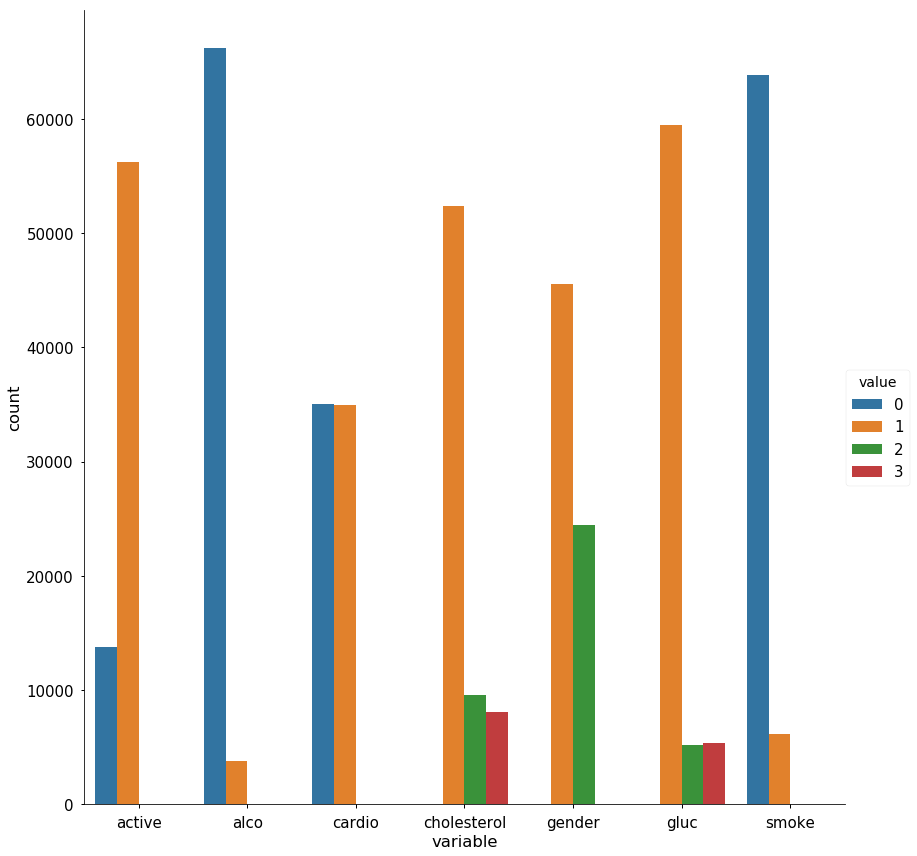

In [5]:
train_uniques = pd.melt(frame=train, value_vars=['gender','cholesterol', 
                                                 'gluc', 'smoke', 'alco', 
                                                 'active', 'cardio'])
train_uniques = pd.DataFrame(train_uniques.groupby(['variable', 
                                                    'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()
    
sns.factorplot(x='variable', y='count', hue='value', 
               data=train_uniques, kind='bar', size=12);

Видим, что классы целевой переменной `cardio` сбалансированы, отлично!

Можно также разбить элементы обучающей выборки по значениям целевой переменной: иногда на таких графиках можно сразу увидеть самый значимый признак.

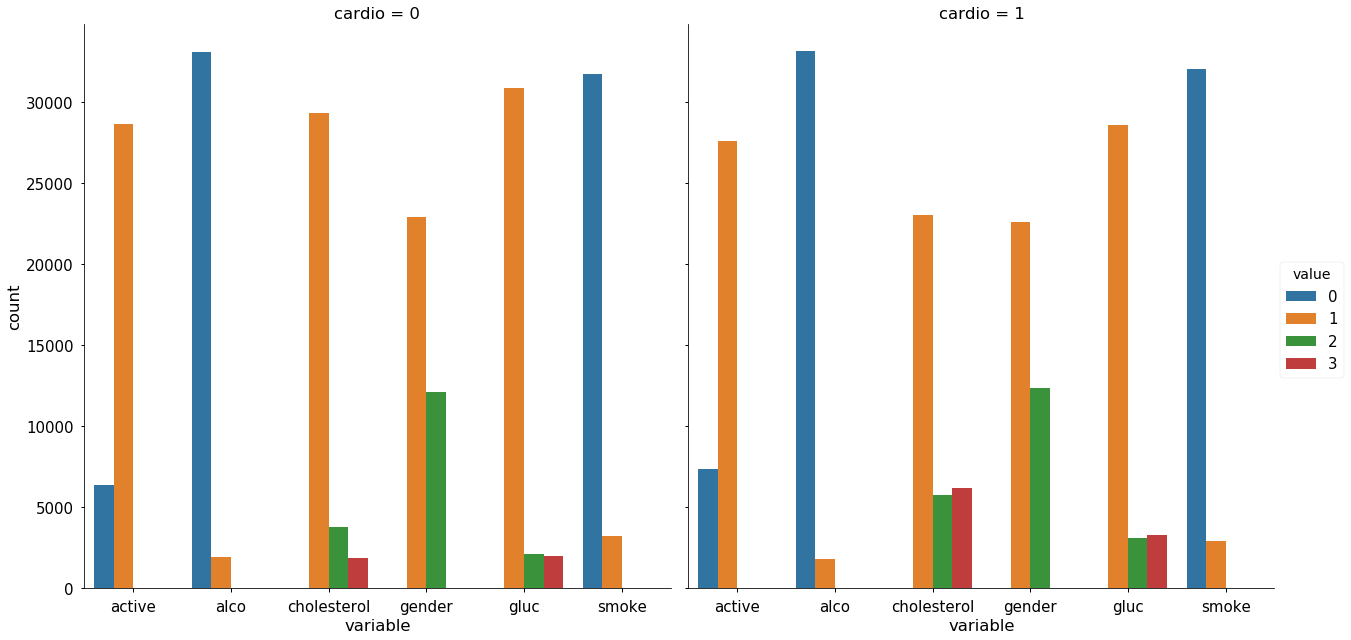

In [6]:
train_uniques = pd.melt(frame=train, value_vars=['gender','cholesterol', 
                                                 'gluc', 'smoke', 'alco', 
                                                 'active'], 
                        id_vars=['cardio'])
train_uniques = pd.DataFrame(train_uniques.groupby(['variable', 'value', 
                                                    'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()
    
sns.factorplot(x='variable', y='count', hue='value', 
               col='cardio', data=train_uniques, kind='bar', size=9);

Видим, что в зависимости от целевой переменной сильно меняется распределение холестерина и глюкозы. Совпадение?

**Немного статистики по уникальным значениям признаков.**

In [7]:
for c in train.columns:
    n = train[c].nunique()
    print(c)
    
    if n <= 3:
        print(n, sorted(train[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

age
8076
----------
gender
(2, [(1L, 45530L), (2L, 24470L)])
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
(3, [(1L, 52385L), (2L, 9549L), (3L, 8066L)])
----------
gluc
(3, [(1L, 59479L), (2L, 5190L), (3L, 5331L)])
----------
smoke
(2, [(0L, 63831L), (1L, 6169L)])
----------
alco
(2, [(0L, 66236L), (1L, 3764L)])
----------
active
(2, [(0L, 13739L), (1L, 56261L)])
----------
cardio
(2, [(0L, 35021L), (1L, 34979L)])
----------


*Итого:*
- Пять количественных признаков (без id)
- Семь категориальных
- 70000 объектов

---

# 1. Визуализируем корреляционную матрицу

Для того чтобы лучше понять признаки в датасете, можно посчитать матрицу коэффициентов корреляции между признаками. <br>

Постройте [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html) корреляционной матрицы. Матрица формируется средствами `Pandas`, со стандартным значением параметров.

###  1. Какие два признака больше всего коррелируют (по Пирсону) с признаком `height` ?

- Gluc, Cholesterol
- Weight, Alco
- Smoke, Alco
- Weight, Gender

In [8]:
train.corr()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.022811,-0.081515,0.053684,0.020764,0.017647,0.154424,0.098703,-0.047633,-0.029723,-0.009927,0.238159
gender,-0.022811,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109
height,-0.081515,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821
weight,0.053684,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660
ap_hi,0.020764,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475
ap_lo,0.017647,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719
cholesterol,0.154424,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147
gluc,0.098703,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307
smoke,-0.047633,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486
alco,-0.029723,0.170966,0.094419,0.067113,0.001408,0.010601,0.035760,0.011246,0.340094,1.000000,0.025476,-0.007330


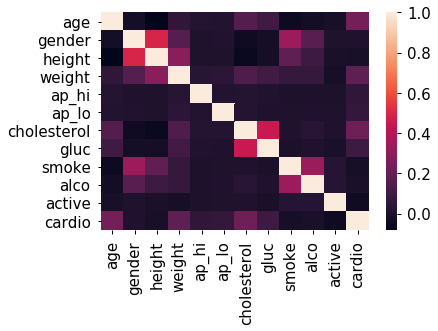

In [9]:
sns.heatmap(train.corr());

In [13]:
#Пол и вес

---

# 2. Распределение роста для мужчин и женщин

Как мы увидели, в процессе исследования уникальных значений пол кодируется значениями 1 и 2, расшифровка изначально не была нам дана в описании данных, но мы догадались, кто есть кто, посчитав средние значения роста (или веса) при разных значениях признака `gender`. Теперь сделаем то же самое, но графически. 

Постройте [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html) для роста и пола. Используйте:
- hue – для разбивки по полу
- scale – для оценки количества каждого из полов 

Для корректной отрисовки, преобразуйте DataFrame в "Long Format"-представление с помощью функции melt в pandas.
<br>
[еще один пример](https://stackoverflow.com/a/41575149/3338479)

In [ ]:
# Ваш код здесь

Постройте на одном графике два отдельных [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) роста, отдельно для мужчин и женщин. На нем разница будет более наглядной, но нельзя будет оценить количество мужчин/женщин.

In [ ]:
# Ваш код здесь

---

# 3. Ранговая корреляция

В большинстве случаев достаточно воспользоваться линейным коэффициентом корреляции *Пирсона* для выявления закономерностей в данных, но мы пойдём чуть дальше и используем ранговую корреляцию, которая поможет нам выявить пары, в которых меньший ранг из вариационного ряда одного признака всегда предшествует большему другого (или наоборот, в случае отрицательной корреляции).

##### Постройте корреляционную матрицу, используя коэффициент Спирмена

### 3.1 Какие признаки теперь больше всего коррелируют (по Спирмену) друг с другом?

- Height, Weight
- Age, Weight
- Ap_hi, Ap_lo
- Cholesterol, Gluc
- Cardio, Cholesterol
- Smoke, Alco

In [10]:
# Ваш код здесь
train.corr(method='spearman')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.020176,-0.082292,0.061559,0.219087,0.156700,0.140113,0.091791,-0.047471,-0.030078,-0.010422,0.234429
gender,-0.020176,1.000000,0.533805,0.172480,0.063174,0.066374,-0.035730,-0.018866,0.338135,0.170966,0.005866,0.008109
height,-0.082292,0.533805,1.000000,0.313569,0.019381,0.030534,-0.058940,-0.024369,0.197632,0.096670,-0.007367,-0.012383
weight,0.061559,0.172480,0.313569,1.000000,0.277749,0.254420,0.137908,0.109901,0.071676,0.068088,-0.014894,0.182701
ap_hi,0.219087,0.063174,0.019381,0.277749,1.000000,0.735436,0.208722,0.105334,0.028929,0.033243,-0.001268,0.451885
ap_lo,0.156700,0.066374,0.030534,0.254420,0.735436,1.000000,0.167401,0.082474,0.026172,0.038862,0.003401,0.362572
cholesterol,0.140113,-0.035730,-0.058940,0.137908,0.208722,0.167401,1.000000,0.407803,0.015220,0.041285,0.007573,0.215117
gluc,0.091791,-0.018866,-0.024369,0.109901,0.105334,0.082474,0.407803,1.000000,0.000468,0.018584,-0.008610,0.091488
smoke,-0.047471,0.338135,0.197632,0.071676,0.028929,0.026172,0.015220,0.000468,1.000000,0.340094,0.025858,-0.015486
alco,-0.030078,0.170966,0.096670,0.068088,0.033243,0.038862,0.041285,0.018584,0.340094,1.000000,0.025476,-0.007330


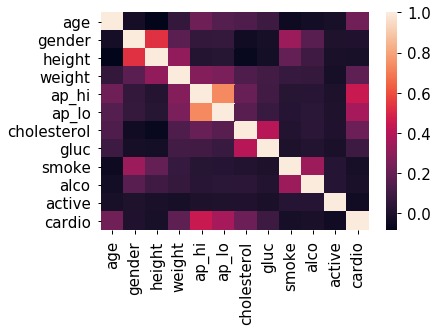

In [5]:
sns.heatmap(train.corr(method='spearman'));

In [18]:
# Два давления

In [39]:
normalized_data = train[(30 <= train['ap_lo']) & (train['ap_lo'] <= 250) & (60 <= train['ap_hi']) \
      & (train['ap_hi'] <= 400) & (train['ap_lo'] < train['ap_hi']) ]

In [40]:
normalized_data.shape

(68678, 14)

In [41]:
spearmanr(normalized_data['ap_lo'], normalized_data['ap_hi'])

SpearmanrResult(correlation=0.7430575256025362, pvalue=0.0)

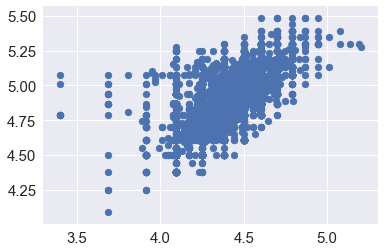

In [42]:
_ = plt.scatter(np.log(normalized_data['ap_lo']), np.log(normalized_data['ap_hi']))

### 3.2 Почему мы получили такое большое (относительно) значение ранговой корреляции у этих признаков?

- Неточности в данных (ошибки при сборе данных)
- Связь ошибочна, переменные никак не должны быть связаны друг с другом
- Природа данных

In [72]:
ap_lo = np.array(train['ap_lo'])
ap_hi = np.array(train['ap_hi'])

In [73]:
ap_lo.shape == ap_hi.shape

True

In [74]:
ap_lo.shape

(70000,)

In [124]:
z = np.arange(10)

In [125]:
z

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [126]:
z.reshape((2, 5))

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [127]:
normalize = lambda x: np.max(np.hstack((x.reshape(x.shape[0], 1), 0.01 + np.zeros(shape=(x.shape[0], 1)))), axis=1)

In [128]:
ap_lo_normalized = normalize(ap_lo)
ap_hi_normalized = normalize(ap_hi)

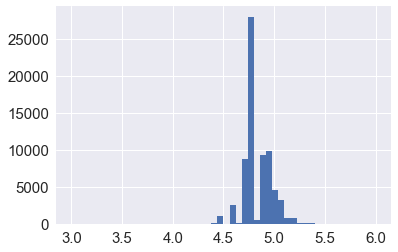

In [131]:
_ = plt.hist(np.log(ap_hi_normalized), bins = 50, range=(3, 6))

In [133]:
np.exp(5.5)

244.69193226422038

In [107]:
len(ap_lo_normalized[(40 <= ap_lo_normalized) & (ap_lo_normalized <= 130)
                    ])

68926

In [134]:
len(ap_hi_normalized[(70 <= ap_hi_normalized) & (ap_hi_normalized <= 250)])

69771

In [135]:
two_columns = np.hstack((ap_lo_normalized.reshape(ap_lo_normalized.shape[0], 1),
                         ap_hi_normalized.reshape(ap_hi_normalized.shape[0], 1)))

In [136]:
two_columns.shape

(70000, 2)

In [139]:
two_columns_filtered = two_columns[(40 <= two_columns[:, 0]) & (two_columns[:, 0] <= 130)
                                   & (70 <= two_columns[:, 1]) & (two_columns[:, 1] <= 250)]

In [140]:
two_columns_filtered.shape

(68715, 2)

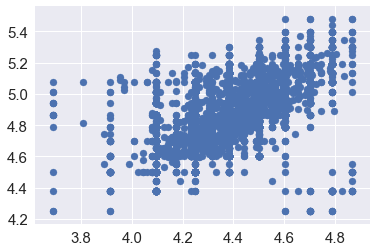

In [141]:
_ = plt.scatter(np.log(two_columns_filtered[:, 0]), np.log(two_columns_filtered[:, 1]))

In [142]:
spearmanr(two_columns_filtered[:, 0], two_columns_filtered[:, 1])

SpearmanrResult(correlation=0.737548557663654, pvalue=0.0)

In [143]:
from scipy.stats import pearsonr

In [144]:
pearsonr(two_columns_filtered[:, 0], two_columns_filtered[:, 1])

(0.7152481293244237, 0.0)

---

# 4. Совместное распределение признаков

Постройте совместный график распределения [jointplot](http://seaborn.pydata.org/generated/seaborn.jointplot.html) двух наиболее коррелирующих между собой признаков (по Спирмену).

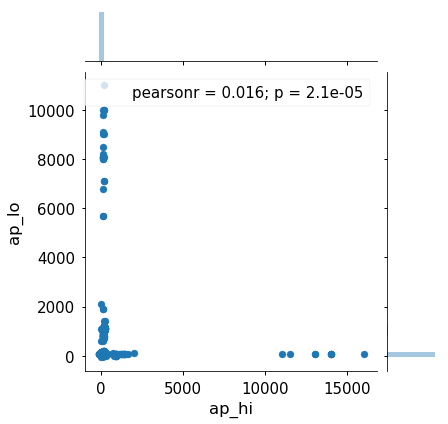

In [27]:
sns.jointplot(train['ap_hi'], train['ap_lo']);

Кажется, наш график получился неинформативным из-за выбросов в значениях. Постройте тот же график, но с логарифмической шкалой (чтобы не получать OverflowError необходимо отфильтровать значения меньше либо равные нулю).

In [28]:
def delete_values(x):
    if x <= 0:
        return -1
    else:
        return np.log(x)
    
train['clear_ap_lo'] = train['ap_lo'].apply(delete_values)
train['clear_ap_hi'] = train['ap_hi'].apply(delete_values)

In [29]:
ap_indexes = train[(train['clear_ap_lo'] == -1) |(train['clear_ap_hi'] == -1)].head()

In [33]:
res = ap_indexes.index

In [34]:
clear_data = train.drop(res)

In [35]:
clear_data.head(20)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,clear_ap_lo,clear_ap_hi
id,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,4.382027,4.700480
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,4.499810,4.941642
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,4.248495,4.867534
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,4.605170,5.010635
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,4.094345,4.605170
8,21914,1,151,67.0,120,80,2,2,0,0,0,0,4.382027,4.787492
9,22113,1,157,93.0,130,80,3,1,0,0,1,0,4.382027,4.867534
12,22584,2,178,95.0,130,90,3,3,0,0,1,1,4.499810,4.867534
13,17668,1,158,71.0,110,70,1,1,0,0,1,0,4.248495,4.700480


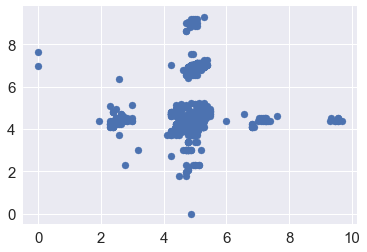

In [36]:
_ = plt.scatter(np.log(clear_data['ap_hi']), np.log(clear_data['ap_lo']))

In [37]:
from scipy.stats import spearmanr
spearmanr(clear_data['clear_ap_lo'], clear_data['clear_ap_hi'])

SpearmanrResult(correlation=0.7355999657710318, pvalue=0.0)

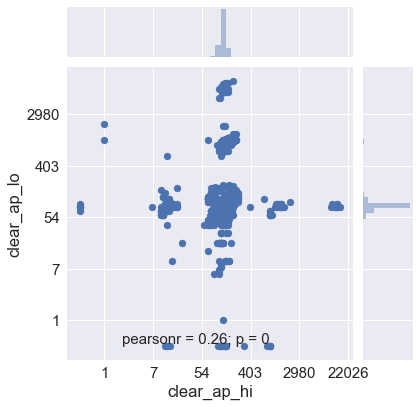

In [38]:
# Ваш код здесь
sns.set(font_scale=1.5)
g = sns.jointplot(clear_data['clear_ap_hi'], clear_data['clear_ap_lo']);

"""Сетка"""
g.ax_joint.grid(True)

"""Преобразуем логарифмические значения на шкалах в реальные"""
g.ax_joint.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: str(int(np.exp(x)))))
g.ax_joint.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: str(int(np.exp(x)))))

### 4.1 Сколько чётко выраженных кластеров получилось на  совместном графике выбранных признаков, с логарифмической шкалой? Под кластером в данной задаче понимается плотное скопление точек, в окрестности которого пренебрежительно мало одиночных наблюдений и которое визуально отделимо от других кластеров.

- 1
- 2
- 3
- больше трёх

In [70]:
# Ваш код здесь
# Больше трех

---

# 5. Возраст

Посчитаем, сколько полных лет было респондентам на момент их занесения в базу.

In [22]:
train['age_years'] = (train['age'] // 365.25).astype(int)

Постройте [Countplot](http://seaborn.pydata.org/generated/seaborn.countplot.html), где на оси абсцисс будет отмечен возраст, на оси ординат – количество. Каждое значение возраста должно иметь два столбца, соответствующих количеству человек каждого класса **cardio** (здоров/болен) данного возраста.

### 5. В каком возрасте количество пациентов с ССЗ  впервые становится больше, чем здоровых?
- 44
- 49
- 53
- 62

In [23]:
data = train.groupby('age_years')

In [24]:
pd.crosstab(train['age_years'], train['cardio'])

cardio,0,1
age_years,,
29,3,0
30,1,0
39,1430,450
40,1194,330
41,1416,588
42,915,400
43,1350,787
44,907,501
45,1317,897


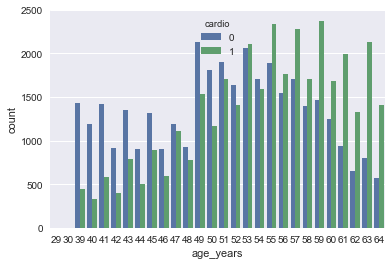

In [32]:
sns.set(font_scale=1.0)
g = sns.countplot(x='age_years', hue='cardio', data=train, orient='h');